In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# IMG_SHAPE = (28, 28, 1)
# BATCH_SIZE = 512

# noise_dim = 128

# fashion_mnist = keras.datasets.fashion_mnist
# (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
# print(f"Number of examples: {len(train_images)}")
# print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

# train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
# train_images = (train_images - 127.5) / 127.5

4423680/4422102 [==============================] - 0s 0us/step
Number of examples: 60000
Shape of the images in the dataset: (28, 28)


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [52]:
from os import listdir, path
from keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm 

input_size=(64, 64, 3)
train_images = np.zeros(shape=(13233, 64, 64, 3))
im_idx = 0

for folder in tqdm(listdir('/content/drive/MyDrive/dataset_gan/dataset')):
  for pic in listdir('/content/drive/MyDrive/dataset_gan/dataset/' + folder):
    if pic[-2:] == 'db':
      continue

    image = load_img(path.join('/content/drive/MyDrive/dataset_gan/dataset', folder, pic), target_size=input_size)
    image = img_to_array(image)
    train_images[im_idx, :, :, :] = image

    im_idx += 1

train_images = train_images.astype("float32")
train_images = (train_images - 127.5) / 127.5
print(im_idx)

100%|██████████| 5749/5749 [00:26<00:00, 218.66it/s]


13233


In [53]:
IMG_SHAPE = input_size
noise_dim = 128
BATCH_SIZE = 512

In [54]:
def conv_block(x, filters, activation, kernel_size=(3, 3), strides=(1, 1), 
               padding="same", use_bias=True, use_bn=False, use_dropout=False, drop_value=0.5):
    
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x

In [55]:
def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)

    x = layers.ZeroPadding2D((2, 2))(img_input)

    x = conv_block(x, 64, kernel_size=(5, 5), strides=(2, 2), use_bn=False, use_bias=True,
        activation=layers.LeakyReLU(0.2), use_dropout=False, drop_value=0.3)
    x = conv_block(x, 128, kernel_size=(5, 5), strides=(2, 2), use_bn=False,
        activation=layers.LeakyReLU(0.2), use_bias=True, use_dropout=True, drop_value=0.3)
    x = conv_block(x, 256, kernel_size=(5, 5), strides=(2, 2), use_bn=False,
        activation=layers.LeakyReLU(0.2), use_bias=True, use_dropout=True, drop_value=0.3)
    x = conv_block(x, 512, kernel_size=(5, 5), strides=(2, 2), use_bn=False,
        activation=layers.LeakyReLU(0.2), use_bias=True, use_dropout=False, drop_value=0.3)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    
    return d_model

In [56]:
d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 68, 68, 3)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 34, 34, 64)        4864      
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 17, 17, 128)       204928    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 17, 17, 128)     

In [57]:
def upsample_block(x, filters, activation, kernel_size=(3, 3), strides=(1, 1), up_size=(2, 2),
    padding="same", use_bn=False, use_bias=True, use_dropout=False, drop_value=0.3):
  
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)

    return x

In [62]:
def get_generator_model():

    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)

    x = upsample_block(x, 128, layers.LeakyReLU(0.2), strides=(1, 1), use_bias=False,
        use_bn=True, padding="same", use_dropout=False)
    x = upsample_block(x, 64, layers.LeakyReLU(0.2), strides=(1, 1), use_bias=False,
        use_bn=True, padding="same", use_dropout=False)
    x = upsample_block(x, 32, layers.LeakyReLU(0.2), strides=(1, 1), use_bias=False,
        use_bn=True, padding="same", use_dropout=False)
    x = upsample_block(x, 3, layers.Activation("tanh"), strides=(1, 1), 
                       use_bias=False, use_bn=True)

    # x = layers.Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")

    return g_model

In [63]:
g_model = get_generator_model()
g_model.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_9 (Dense)              (None, 4096)              524288    
_________________________________________________________________
batch_normalization_21 (Batc (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d_16 (UpSampling (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 8, 8, 128)         29

In [64]:
class WGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, discriminator_extra_steps=3, gp_weight=10.0):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    # Function called at each batch
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]

        for i in range(self.d_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_logits = self.discriminator(fake_images, training=True)
                real_logits = self.discriminator(real_images, training=True)

                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                d_loss = d_cost + gp * self.gp_weight

            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            g_loss = self.g_loss_fn(gen_img_logits)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

In [65]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.preprocessing.image.array_to_img(img)
            img.save("generated_img_{epoch}_{i}.png".format(epoch=epoch, i=i))

In [ ]:
class CheckDiscriminator(keras.callbacks.Callback):
    def __init__(self, latent_dim=128, num_img=100):
        self.latent_dim = latent_dim
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)

        y_fake = np.ones(shape=self.num_img)
        _, acc_fake = self.model.discriminator.evaluate(generated_images, y_fake, verbose=0)

        print('Dsicriminator accuracy on fake images:', acc_fake*100)

In [66]:
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

In [67]:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

epochs = 20

cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

wgan = WGAN(discriminator=d_model, generator=g_model, latent_dim=noise_dim, discriminator_extra_steps=3)
wgan.compile(d_optimizer=discriminator_optimizer, g_optimizer=generator_optimizer, 
             g_loss_fn=generator_loss, d_loss_fn=discriminator_loss)

In [68]:
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

Epoch 1/20
26/26 [==============================] - 124s 4s/step - d_loss: -40.9915 - g_loss: 16.9703
Epoch 2/20
26/26 [==============================] - 108s 4s/step - d_loss: -34.4502 - g_loss: -34.5598
Epoch 3/20
26/26 [==============================] - 108s 4s/step - d_loss: -30.2501 - g_loss: -40.8142
Epoch 4/20
26/26 [==============================] - 108s 4s/step - d_loss: -29.5198 - g_loss: -44.9920
Epoch 5/20
26/26 [==============================] - 108s 4s/step - d_loss: -30.4885 - g_loss: -32.6837
Epoch 6/20
26/26 [==============================] - 108s 4s/step - d_loss: -30.4192 - g_loss: -31.7397
Epoch 7/20
26/26 [==============================] - 108s 4s/step - d_loss: -30.2902 - g_loss: -27.2754
Epoch 8/20
26/26 [==============================] - 108s 4s/step - d_loss: -30.2523 - g_loss: -26.6166
Epoch 9/20
26/26 [==============================] - 108s 4s/step - d_loss: -29.9408 - g_loss: -29.9098
Epoch 10/20
26/26 [==============================] - 108s 4s/step - d_loss

In [70]:
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

Epoch 1/20
26/26 [==============================] - 103s 4s/step - d_loss: -22.6850 - g_loss: -17.1074
Epoch 2/20
26/26 [==============================] - 105s 4s/step - d_loss: -22.4166 - g_loss: -15.0860
Epoch 3/20
26/26 [==============================] - 106s 4s/step - d_loss: -21.5158 - g_loss: -11.5894
Epoch 4/20
26/26 [==============================] - 106s 4s/step - d_loss: -20.9503 - g_loss: -10.9585
Epoch 5/20
26/26 [==============================] - 106s 4s/step - d_loss: -20.9726 - g_loss: -12.8447
Epoch 6/20
26/26 [==============================] - 107s 4s/step - d_loss: -20.1798 - g_loss: -18.0936
Epoch 7/20
26/26 [==============================] - 107s 4s/step - d_loss: -19.9815 - g_loss: -17.9368
Epoch 8/20
26/26 [==============================] - 107s 4s/step - d_loss: -19.6568 - g_loss: -33.6281
Epoch 9/20
26/26 [==============================] - 107s 4s/step - d_loss: -19.2813 - g_loss: -40.5207
Epoch 10/20
26/26 [==============================] - 107s 4s/step - d_los

In [51]:
from IPython.display import Image, display

In [50]:
# 20 first epochs of model with size 28x28
for i in range(epochs):
  display(Image("generated_img_" + str(i) + "_0.png", width=128, height=128))

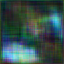

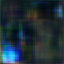

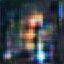

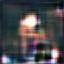

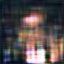

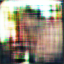

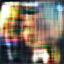

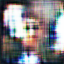

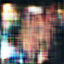

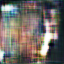

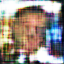

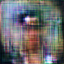

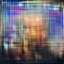

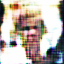

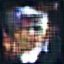

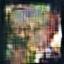

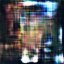

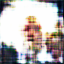

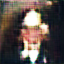

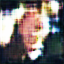

In [69]:
# 20 first epochs of model with size 64x64
for i in range(epochs):
  display(Image("generated_img_" + str(i) + "_0.png", width=128, height=128))

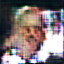

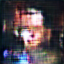

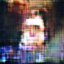

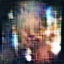

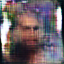

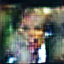

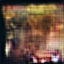

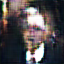

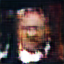

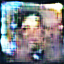

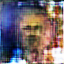

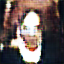

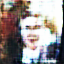

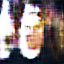

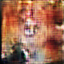

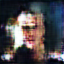

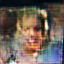

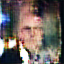

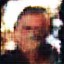

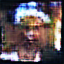

In [71]:
# epochs 20-40 of model with size 64x64
for i in range(epochs):
  display(Image("generated_img_" + str(i) + "_0.png", width=128, height=128))